# 5.6. 深度卷积神经网络（AlexNet）

神经网络可以直接基于图像的原始像素进行分类。这种称为端到端（end-to-end）的方法节省了很多中间步骤。然而，在很长一段时间里更流行的是研究者通过勤劳与智慧所设计并生成的手工特征。
这类图像分类研究的主要流程是：

* 获取图像数据集；
* 使用已有的特征提取函数生成图像的特征；
* 使用机器学习模型对图像的特征分类。

## 5.6.1 学习特征表示

多层神经网络可能可以学得数据的多级表征，并逐级表示越来越抽象的概念或模式。以图像分类为例，并回忆5.1节（二维卷积层）中物体边缘检测的例子。在多层神经网络中，图像的第一级的表示可以是在特定的位置和⻆度是否出现边缘；而第二级的表示说不定能够将这些边缘组合出有趣的模式，如花纹；在第三级的表示中，也许上一级的花纹能进一步汇合成对应物体特定部位的模式。这样逐级表示下去，最终，模型能够较容易根据最后一级的表示完成分类任务。需要强调的是，输入的逐级表示由多层模型中的参数决定，而这些参数都是学出来的。

## 5.6.2 AlexNet

2012年，AlexNet横空出世。这个模型的名字来源于论文第一作者的姓名Alex Krizhevsky [1]。AlexNet使用了8层卷积神经网络，并以很大的优势赢得了ImageNet 2012图像识别挑战赛。它首次证明了学习到的特征可以超越手工设计的特征，从而一举打破计算机视觉研究的前状。

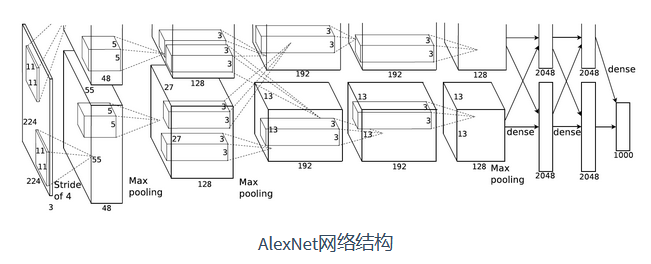

AlexNet与LeNet的设计理念非常相似，但也有显著的区别。

第一，与相对较小的LeNet相比，AlexNet包含8层变换，其中有5层卷积和2层全连接隐藏层，以及1个全连接输出层。

AlexNet第一层中的卷积窗口形状是11×11。因为ImageNet中绝大多数图像的高和宽均比MNIST图像的高和宽大10倍以上，ImageNet图像的物体占用更多的像素，所以需要更大的卷积窗口来捕获物体。第二层中的卷积窗口形状减小到5×5，之后全采用3×3。此外，第一、第二和第五个卷积层之后都使用了窗口形状为3×3、步幅为2的最大池化层。而且，AlexNet使用的卷积通道数也大于LeNet中的卷积通道数数十倍。

紧接着最后一个卷积层的是两个输出个数为4096的全连接层。这两个巨大的全连接层带来将近1 GB的模型参数。由于早期显存的限制，最早的AlexNet使用双数据流的设计使一个GPU只需要处理一半模型。

第二，AlexNet将sigmoid激活函数改成了更加简单的ReLU激活函数。一方面，ReLU激活函数的计算更简单，例如它并没有sigmoid激活函数中的求幂运算。另一方面，ReLU激活函数在不同的参数初始化方法下使模型更容易训练。这是由于当sigmoid激活函数输出极接近0或1时，这些区域的梯度几乎为0，从而造成反向传播无法继续更新部分模型参数；而ReLU激活函数在正区间的梯度恒为1。因此，若模型参数初始化不当，sigmoid函数可能在正区间得到几乎为0的梯度，从而令模型无法得到有效训练。

第三，AlexNet通过丢弃法（参见3.13节）来控制全连接层的模型复杂度。而LeNet并没有使用丢弃法。

第四，AlexNet引入了大量的图像增广，如翻转、裁剪和颜色变化，从而进一步扩大数据集来缓解过拟合。

In [1]:
import time
import torch
from torch import nn,optim
import torchvision

import sys
sys.path.append("..")
import d2lzh_pytorch as d2l
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()
        #卷积层
        self.conv=nn.Sequential(
            nn.Conv2d(1,96,11,4),#input_channels,output_channels,kernel_size,stride,padding
            nn.ReLU(),
            nn.MaxPool2d(3,2),#kernel_size,stride
            #减小卷积窗口，使用填充为2使得输入与输出的高与宽一致，且增大通道数
            nn.Conv2d(96,256,5,1,2),
            nn.ReLU(),
            nn.MaxPool2d(3,2),#kernel_size,stride
    # 连续3个卷积层，且使用更小的卷积窗口。除了最后的卷积层外，进一步增大了输出通道数。
    # 前两个卷积层后不使用池化层来减小输入的高和宽
            nn.Conv2d(256,384,3,1,1),
            nn.ReLU(),
            nn.Conv2d(384,384,3,1,1),
            nn.ReLU(),
            nn.Conv2d(384,256,3,1,1),
            nn.ReLU(),
            nn.MaxPool2d(3,2)#池化层---取窗口的最大值
        )
        #全连接层
        self.fc=nn.Sequential(
            nn.Linear(256*5*5,4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096,4096),
            nn.ReLU(),
            nn.Dropout(0.5),
     # 输出层。由于这里使用Fashion-MNIST，所以用类别数为10.
            nn.Linear(4096,10),
        )
    
    def  forward(self,img):
        feature=self.conv(img)
        output=self.fc(feature.view(img.shape[0],-1))
        #img.shape[0]为样本数，另一个维度为特征向量的长度
        return output

In [2]:
net=AlexNet()
print(net)

AlexNet(
  (conv): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=6400, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (

## 5.6.3 读取数据

读取数据的时候我们额外做了一步将图像高和宽扩大到AlexNet使用的图像高和宽224。这个可以通过torchvision.transforms.Resize实例来实现。也就是说，我们在ToTensor实例前使用Resize实例，然后使用Compose实例来将这两个变换串联以方便调用。

In [3]:
def  load_data_fashion_mnist(batch_size,root,resize=None):
    trans=[]
    if resize:
        trans.append(torchvision.transforms.Resize(size=resize))
    trans.append(torchvision.transforms.ToTensor())
    
    transform=torchvision.transforms.Compose(trans)
    mnist_train=torchvision.datasets.FashionMNIST(root=root,train=True,transform=transform)
    mnist_test=torchvision.datasets.FashionMNIST(root=root,train=False,download=True,transform=transform)
    #num_workers多进程读取数据
    train_iter=torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=4)
    test_iter=torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=False,num_workers=4)
    
    return train_iter,test_iter

batch_size=128
# 如出现“out of memory”的报错信息，可减小batch_size或resize
train_iter,test_iter=load_data_fashion_mnist(batch_size,resize=224,root='../Datasets/FashionMNIST')

## 5.6.4 训练

In [ ]:
lr,num_epochs=0.001,5
optimizer=torch.optim.Adam(net.parameters(),lr=lr)
d2l.train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs)

training on  cpu


## 参考文献

[1] Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). Imagenet classification with deep convolutional neural networks. In Advances in neural information processing systems (pp. 1097-1105).